In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mdtraj as md

import torch
from torch import nn

from snrv import Snrv

In [3]:
traj = md.load("../traj_2000_2500.dcd", top="../em.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if
                              (atom.residue.name != 'HOH' and atom.element.symbol != "H")])
pos = torch.from_numpy(traj.xyz)
box = torch.from_numpy(np.asarray([np.diag(i) for i in traj.unitcell_vectors])).view(-1, 1, 3)

In [4]:
def generate_pair_indices_from_list(index_list):
    i_list = []
    j_list = []
    for i in range(len(index_list)):
        for j in range(i + 1, len(index_list)):
            i_list.append(index_list[i])
            j_list.append(index_list[j])
    return torch.tensor(i_list), torch.tensor(j_list)

i_list, j_list = generate_pair_indices_from_list(biasing_atom_ids)

In [5]:
d = pos[:, i_list, :] - pos[:, j_list, :]  # shape: [T, M, 3]
d = d - box * torch.round(d / box)  # apply MIC
traj_x = torch.norm(d, dim=-1)  # shape: [T, M]
traj_x = traj_x.to(torch.double)

In [7]:
class PCAModule(nn.Module):
    def __init__(self, n_components: int):
        """
        A differentiable and torchscript-compatible PCA module.
        
        Args:
            n_components (int): Number of principal components to retain.
        """
        super().__init__()
        self.n_components = n_components
        self.register_buffer("mean", torch.tensor([]))  # shape (D,)
        self.register_buffer("components", torch.tensor([]))  # shape (D, k)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fit PCA on input data and return the projection.

        Args:
            x (torch.Tensor): Input tensor of shape (N, D)

        Returns:
            torch.Tensor: PCA-transformed tensor of shape (N, n_components)
        """
        # Center the input
        mean = x.mean(dim=0, keepdim=True)
        x_centered = x - mean

        # Compute covariance matrix
        cov = torch.matmul(x_centered.T, x_centered) / (x_centered.size(0) - 1)

        # Eigendecomposition
        eigvals, eigvecs = torch.linalg.eigh(cov)

        # Sort eigenvectors by eigenvalue magnitude
        sorted_indices = torch.argsort(eigvals, descending=True)
        topk_eigvecs = eigvecs[:, sorted_indices[:self.n_components]]  # (D, k)

        # Save for future transform
        self.mean = mean.squeeze(0)
        self.components = topk_eigvecs

        # Project
        return torch.matmul(x_centered, topk_eigvecs)

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Project new data using the previously learned principal components.

        Args:
            x (torch.Tensor): New input tensor of shape (N, D)

        Returns:
            torch.Tensor: Projected tensor of shape (N, n_components)
        """
        x_centered = x - self.mean
        return torch.matmul(x_centered, self.components)


In [8]:
model = PCAModule(2)
projected_train_x = model(traj_x)

Text(0, 0.5, 'PC1')

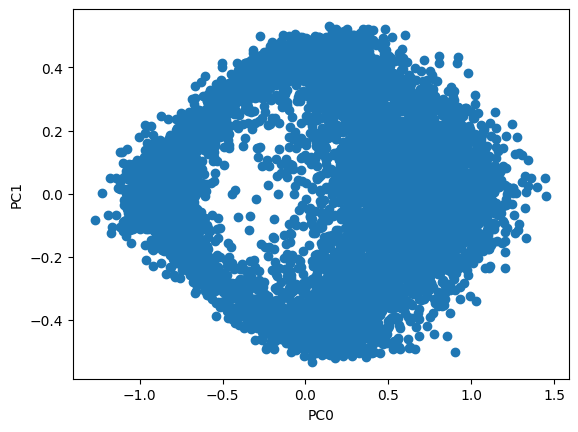

In [9]:
plt.scatter(projected_train_x[:, 0], projected_train_x[:, 1])
plt.xlabel("PC0")
plt.ylabel("PC1")

In [10]:
class CV(torch.nn.Module):
    def __init__(self, model, idx):
        super().__init__()
        self.model = model
        self.idx = idx
        self.register_buffer("i_list", i_list)
        self.register_buffer("j_list", j_list)

    def forward(self, positions, boxvectors):
        """The forward method returns the energy computed from positions.

        Parameters
        ----------
        positions : torch.Tensor with shape (nparticles, 3)
           positions[i,k] is the position (in nanometers) of spatial dimension k of particle i

        Returns
        -------
        potential : torch.Scalar
           The potential energy (in kJ/mol)
        """
        boxsize = boxvectors.diag()
        d = positions[self.i_list, :] - positions[self.j_list, :]  # shape: [M, 3]
        d = d - boxsize * torch.round(d / boxsize)  # apply MIC
        feats = torch.norm(d, dim=-1)  # shape: [T, M]
        evecs = self.model.transform(feats.view(1, -1))
        CV = evecs[0][self.idx]
        return CV

model_output_1 = CV(model, 0)
model_output_2 = CV(model, 1)

torch.jit.script(model_output_1).save('cv1.pt')
torch.jit.script(model_output_2).save('cv2.pt')